<a href="https://colab.research.google.com/github/Ps1231/Emotion-Analysis-BERT-Model/blob/main/Heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Path to dataset files: /kaggle/input/heart-disease-data


In [1]:
# -*- coding: utf-8 -*-
"""
M.Tech (IT) - IX Semester
MACHINE LEARNING - 3rd Internal Assignment
Title: Heart Disease Prediction using Random Forest & SVM
Author: [YOUR NAME]
Roll No: [YOUR ROLL]
"""

# ========================================
# 0. IMPORTS
# ========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)

sns.set(style="whitegrid", font_scale=1.1)
%matplotlib inline

In [4]:
# ========================================
# 1. LOAD DATASET
# ========================================
data_path = "/kaggle/input/heart-disease-data/heart_disease_uci.csv"
df = pd.read_csv(data_path)
print("Raw Shape:", df.shape)
df.head()

Raw Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [5]:
# ========================================
# 2. DATA PREPROCESSING & CLEANING (FIXED)
# ========================================
# Drop non-predictive columns
cols_to_drop = ['id', 'dataset', 'ca', 'thal']
df_clean = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Create binary target only if 'num' exists
if 'num' in df_clean.columns:
    df_clean['target'] = (df_clean['num'] > 0).astype(int)
    df_clean = df_clean.drop('num', axis=1)
else:
    print("'num' already processed.")

print("Cleaned Shape:", df_clean.shape)
print("\nTarget Distribution:")
print(df_clean['target'].value_counts())

Cleaned Shape: (920, 12)

Target Distribution:
target
1    509
0    411
Name: count, dtype: int64


In [6]:
# Missing values
print("\nMissing Values:")
print(df_clean.isnull().sum())


Missing Values:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
target        0
dtype: int64


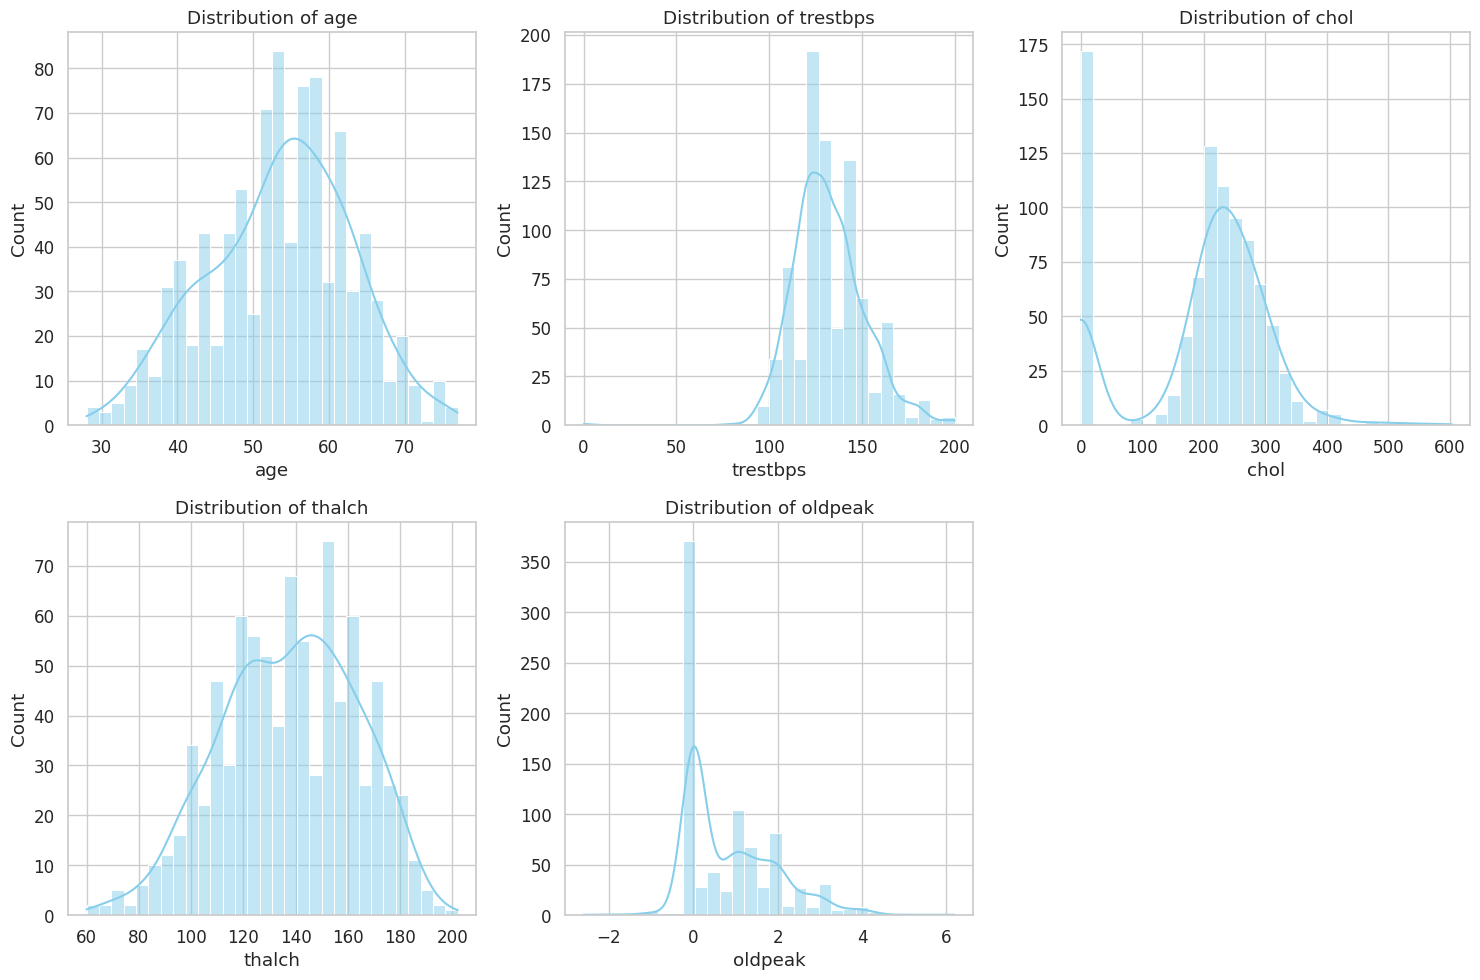

In [7]:
# ========================================
# 2. EDA: Distributions
# ========================================
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_clean[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

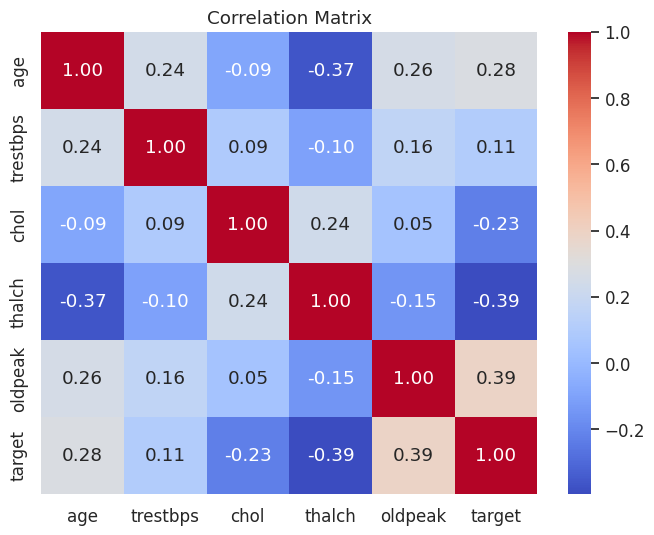

In [8]:
# ========================================
# 2. EDA: Correlation
# ========================================
plt.figure(figsize=(8, 6))
corr = df_clean[numeric_cols + ['target']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# ========================================
# 3. PREPROCESSING PIPELINE
# ========================================
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
])

In [10]:
# ========================================
# 4. TRAIN-TEST SPLIT
# ========================================
X = df_clean.drop('target', axis=1)
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")

Train: (736, 11) | Test: (184, 11)


In [11]:
# ========================================
# 5. MODEL 1: RANDOM FOREST + GRIDSEARCH
# ========================================
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

rf_params = {
    'rf__n_estimators': [300, 500],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best RF CV AUC:", rf_grid.best_score_)
print("Best Params:", rf_grid.best_params_)

Best RF CV AUC: 0.8725043921249883
Best Params: {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


In [12]:
# ========================================
# 6. MODEL 2: SVM + GRIDSEARCH
# ========================================
svm_pipe = Pipeline([
    ('prep', preprocessor),
    ('svm', SVC(probability=True, random_state=42, class_weight='balanced'))
])

svm_params = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(svm_pipe, svm_params, cv=cv, scoring='roc_auc', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best SVM CV AUC:", svm_grid.best_score_)
print("Best Params:", svm_grid.best_params_)

Best SVM CV AUC: 0.8786161735484228
Best Params: {'svm__C': 1, 'svm__kernel': 'rbf'}



=== Random Forest ===
Accuracy : 0.8424
F1-Score : 0.8599
ROC-AUC  : 0.9154
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        82
           1       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



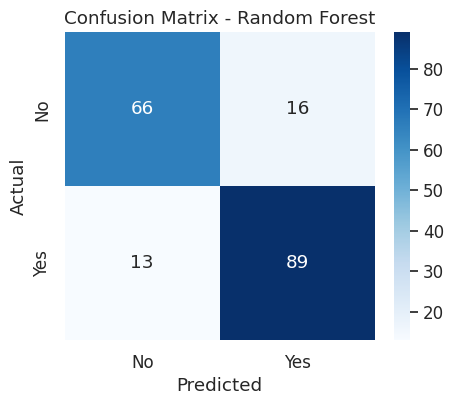

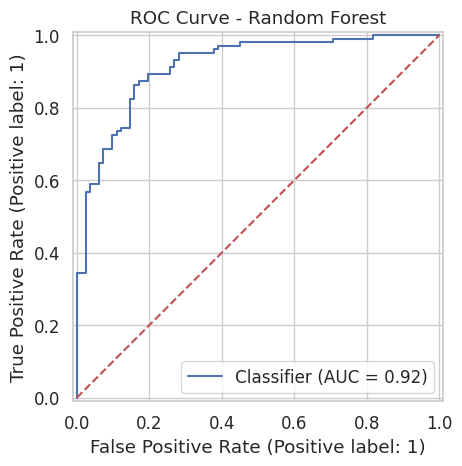


=== SVM ===
Accuracy : 0.8370
F1-Score : 0.8571
ROC-AUC  : 0.8942
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        82
           1       0.83      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



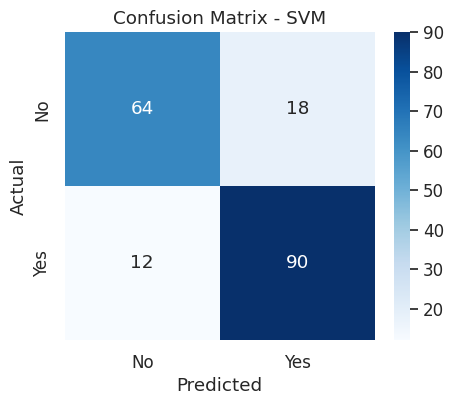

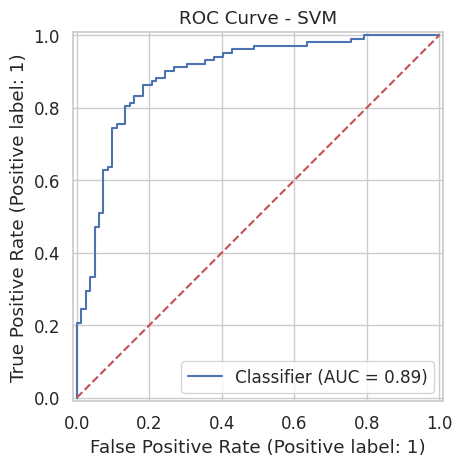

In [13]:
# ========================================
# 7. EVALUATION FUNCTION
# ========================================
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual'); plt.xlabel('Predicted')
    plt.show()

    # ROC
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.plot([0,1],[0,1],'r--')
    plt.title(f'ROC Curve - {name}')
    plt.show()

evaluate(rf_grid.best_estimator_, "Random Forest")
evaluate(svm_grid.best_estimator_, "SVM")

In [14]:
# ========================================
# 8. COMPARISON TABLE
# ========================================
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM'],
    'CV ROC-AUC': [rf_grid.best_score_, svm_grid.best_score_],
    'Test Accuracy': [accuracy_score(y_test, rf_grid.predict(X_test)),
                      accuracy_score(y_test, svm_grid.predict(X_test))],
    'Test ROC-AUC': [roc_auc_score(y_test, rf_grid.predict_proba(X_test)[:,1]),
                     roc_auc_score(y_test, svm_grid.predict_proba(X_test)[:,1])],
    'Test F1': [f1_score(y_test, rf_grid.predict(X_test)),
                f1_score(y_test, svm_grid.predict(X_test))]
}).round(4)

print("MODEL COMPARISON")
results

MODEL COMPARISON


,Model,CV ROC-AUC,Test Accuracy,Test ROC-AUC,Test F1
0,Random Forest,0.8725,0.8424,0.9154,0.8599
1,SVM,0.8786,0.8370,0.8942,0.8571


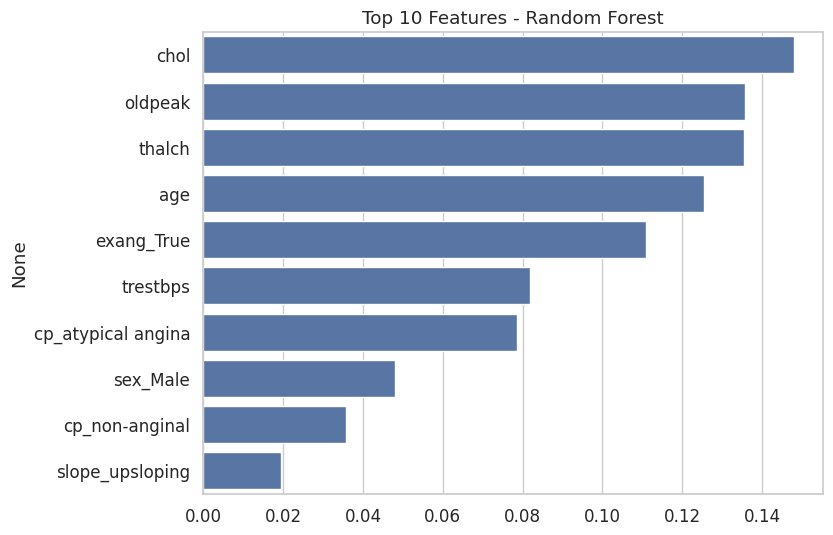

In [15]:
# ========================================
# 9. FEATURE IMPORTANCE
# ========================================
rf = rf_grid.best_estimator_.named_steps['rf']
ohe = rf_grid.best_estimator_.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
cat_names = ohe.get_feature_names_out(categorical_features)
feat_names = numeric_features + list(cat_names)

imp = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=imp.values[:10], y=imp.index[:10])
plt.title('Top 10 Features - Random Forest')
plt.show()